In [11]:
from azure.storage.blob import BlobServiceClient, ContainerClient, BlobPrefix
import cv2
import imageio.v3 as iio
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from PIL import Image
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from torchviz import make_dot
from copy import deepcopy

# Get the directory of the current script file
os.chdir(r'C:\Users\Ecko_\exjobb_jupyter')
print(os.getcwd())

C:\Users\Ecko_\exjobb_jupyter


### Blob Storage Set-up

In [12]:
STORAGEACCOUNTURL = "https://exjobbssl1863219591.blob.core.windows.net"
STORAGEACCOUNTKEY = "PuL1QY8bQvIyGi653lr/9CPvyHLnip+cvsu62YAipDjB7onPDxfME156z5/O2NwY0PRLMTZc86/6+ASt5Vts8w=="
CONTAINERNAME = "exjobbssl"
FOLDERNAME = "UCF-101/ApplyLipstick/"
#BLOBNAME = "UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi"

blob_service_client_instance = BlobServiceClient(
    account_url=STORAGEACCOUNTURL, credential=STORAGEACCOUNTKEY)

# CALL SPECIFIC BLOB
# #blob_client_instance = blob_service_client_instance.get_blob_client(
#    CONTAINERNAME, BLOBNAME, snapshot=None)
#blob_data = blob_client_instance.download_blob()
#data = blob_data.readall()

container_client_instance = blob_service_client_instance.get_container_client(CONTAINERNAME)
#blob_list = container_client_instance.list_blobs()

### Load Videos Into Memory

In [13]:
class BlobSamples(object):
    def __init__(self):
        self.depth = 0
        self.indent = "  "

    def list_blobs_hierarchical(self, container_client: ContainerClient, prefix):
        for blob in container_client_instance.walk_blobs(name_starts_with=prefix, delimiter='/'):
            if isinstance(blob, BlobPrefix):
                # Indentation is only added to show nesting in the output
                print(f"{self.indent * self.depth}{blob.name}")
                self.depth += 1
                self.list_blobs_hierarchical(container_client_instance, prefix=blob.name)    
                self.depth -= 1
                #print('hi')
            else:
                print(f"{self.indent * self.depth}{blob.name}")

    def load_videos_into_memory(self, blob_service_client: BlobServiceClient, container_name, folder_name, videos_loaded):
        container_client = blob_service_client.get_container_client(container=container_name)

        blob_list = container_client.list_blobs(name_starts_with=folder_name)

        videos = []
        counter = 0  # Add a counter
        for blob in blob_list:
            if counter >= videos_loaded:  # Break the loop after loading 5 videos
                break
            blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob.name)
            video_data = blob_client.download_blob().readall()

            # Create a dictionary for the video
            video = {
                'path': blob.name,  # The path of the video
                'data': video_data  # The bytes data of the video
            }

            videos.append(video)
            counter += 1  # Increment the counter
        return videos

# LIST ALL FOLDERS – Usage of the hierarchical list_blobs function
#sample = BlobSamples()
#sample.list_blobs_hierarchical(container_client_instance, "")

# Usage:
sample = BlobSamples()

videos_loaded = 200
print('loading videos')
videos = sample.load_videos_into_memory(blob_service_client_instance, CONTAINERNAME, FOLDERNAME, videos_loaded)
print('videos loaded')
print("Amount of videos loaded: " + str(len(videos)))

loading videos
videos loaded
Amount of videos loaded: 114


### Read Frame From Blob Storage – OPTIONAL

In [14]:
def read_frames_from_first_n_videos(videos, n):
    for video_data in videos[:n]:  # Only take the first n videos
        frames = iio.imread(video_data, index=None, format_hint=".avi")
        #frames.shape
        # Output:
        #(165 frames, 240x320 pixels, 3 channels)

        frame = frames[0]
        cv2.imshow("image", frame)
        if cv2.waitKey(0) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

# Usage:
amount_of_videos_to_load = 1
#read_frames_from_first_n_videos(videos, amount_of_videos_to_load)

### Prepare Datasets

In [36]:
class PreparedDataset(Dataset):
    def __init__(self, videos, trainval='train'):
        self.video_names_train = []
        self.video_names_test = []
        self.action_labels_train = []
        self.action_labels_test = []
        self.predata_train = []
        self.predata_test = []
        self.videos = videos
        self.trainval = trainval

        # Read the classes file
        with open('classInd.txt', 'r') as f:
            classes = f.readlines()
        classes = [c.strip().split(' ', 1)[1] for c in classes]
        self.class_to_id = {c: i for i, c in enumerate(classes)} #dictionary

        # First, read the paths and labels from the trainlist and testlist files into dictionaries
        train_paths = {}
        test_paths = {}
        with open('trainlist1.txt', 'r') as f:
            for line in f:
                path, label = line.strip().split(' ')
                train_paths[path] = int(label)-1  # Subtract 1 to make the labels 0-indexed
        with open('testlist1.txt', 'r') as f:
            test_paths = {line.strip() for line in f}
        for video in videos:
            path = video['path'][len('UCF-101/'):]  # Remove the 'UCF-101/' prefix from the video path
            video_name = path.split('/')[1].split('.avi')[0].replace('v_', '') #Extracting the name
            if path in train_paths:
                self.video_names_train.append(video_name)
                label = train_paths[path]  # Extract the label from the dictionary
                self.action_labels_train.append(label)
                self.predata_train.append(video)
            elif path in test_paths:
                self.video_names_test.append(video_name)
                class_name = path.split('/')[0]
                label = self.class_to_id[class_name]
                self.action_labels_test.append(label)
                self.predata_test.append(video)

    def __getitem__(self, index):  # https://stackoverflow.com/questions/43627405/understanding-getitem-method-in-python
        if self.trainval == 'train':
            video_name = self.video_names_train[index]
            label = self.action_labels_train[index]
            video = self.predata_train[index]
        else:
            video_name = self.video_names_test[index]
            label = self.action_labels_test[index]
            video = self.predata_test[index]
            
        # Convert the bytes to frames
        #video = iio.imread(video_bytes, index=None, format_hint=".avi")

        return video, label, video_name

    def __len__(self):
        if self.trainval == "train":
            return len(self.predata_train)
        else:
            return len(self.predata_test)

### Train/test Dataset Test

Number of training videos: 82
Number of testing videos: 32


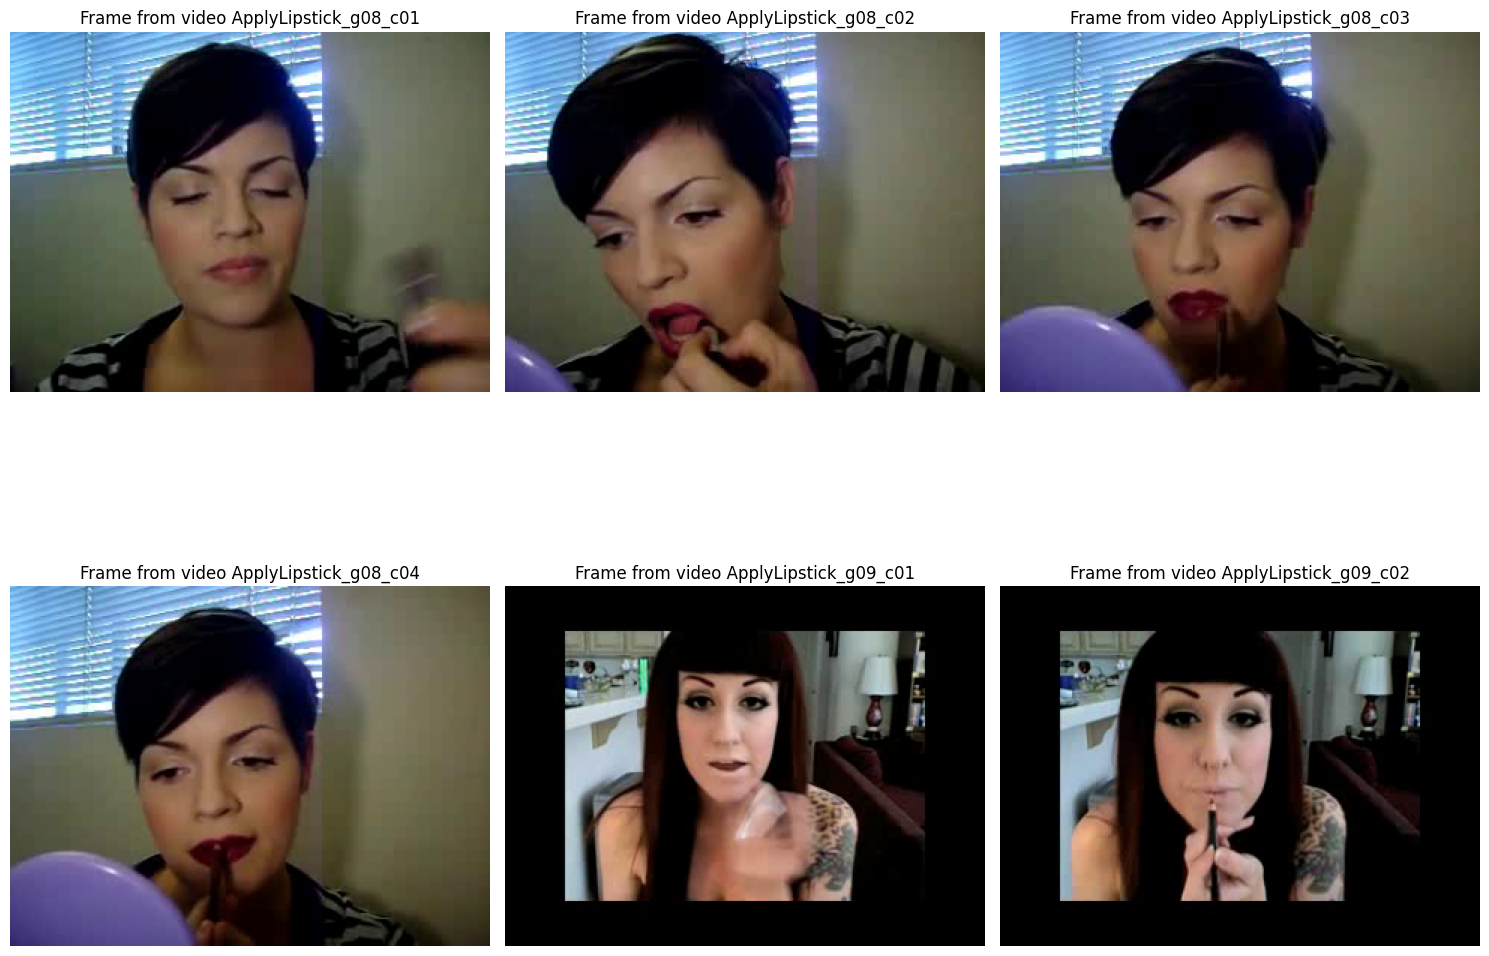

In [51]:
# Initialize the train/test dataset
video_dataset = PreparedDataset(videos, trainval='train')

# Print the first 5 file paths from filelist_train and filelist_test
def test_video_dataset(dataset, n):
    print(f"Number of training videos: {len(dataset.predata_train)}")
    print(f"Number of testing videos: {len(dataset.predata_test)}")

    #print(dataset.actionlabels_train[:15])
    #print(dataset.actionlabels_test[:15])

    #print(dataset.video_names_train[:15])
    #print(dataset.video_names_test[:15])

    fig, axs = plt.subplots(nrows=(n+2)//3, ncols=3, figsize=(15, 5*(n+2)//3))

    # Display the first n videos from the training data
    for i, video_data in enumerate(dataset.predata_train[:n]):  # Only take the first n videos from training data
        frames = iio.imread(video_data['data'], index=None, format_hint=".avi")
        frame = frames[0]

        # Display the frame using pyplot
        axs[i//3, i%3].imshow(frame)
        axs[i//3, i%3].set_title(f'Frame from video {dataset.video_names_train[i]}')
        axs[i//3, i%3].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
amount_of_videos_to_display = 6
test_video_dataset(video_dataset, amount_of_videos_to_display)

### Image Re-ordering & Preprocessing

(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)


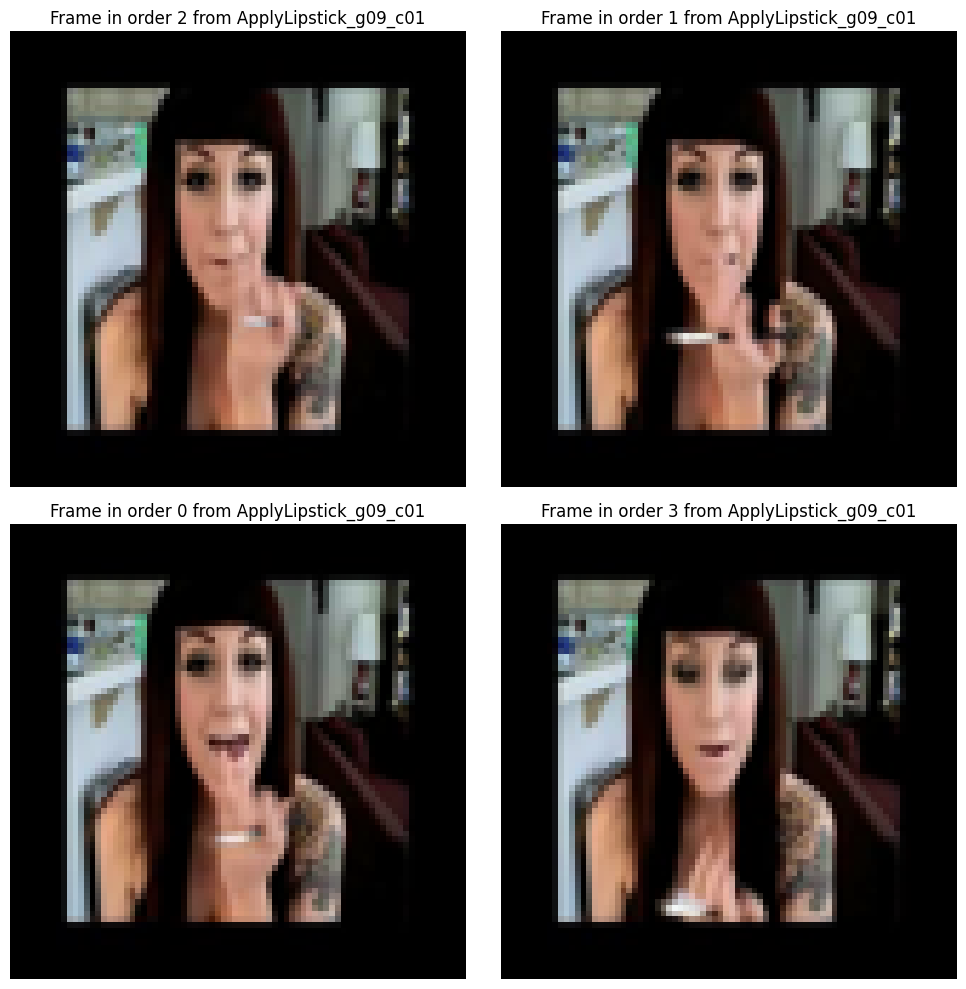

In [47]:
class PreprocessedTemporalFourData(Dataset):
    def __init__(self, dataset, trainval='train', mean=[96.5, 96.5, 96.5], imagesize=80):
        self.dataset = dataset
        self.trainval = trainval
        self.mean = mean
        self.imagesize = imagesize
        
    def __len__(self):
        if self.trainval == 'train':
            return len(self.dataset.predata_train)
        else:
            return len(self.dataset.predata_test)

    def __getitem__(self, index):
        #print(f"Index: {index}, Length of predata_test: {len(self.dataset.predata_test)}")
        #print(f"Trainval: {self.trainval}")
        if self.trainval == 'train':
            video = self.dataset.predata_train[index]
            action_label = self.dataset.action_labels_train[index]
            video_name = self.dataset.video_names_train[index]
        else:
            try:
                video = self.dataset.predata_test[index]
                action_label = self.dataset.action_labels_test[index]
                video_name = self.dataset.video_names_test[index]
            except IndexError:
                print(f"IndexError for index: {index}")
                raise

        # Randomly select 4 frames from the video
        frames = iio.imread(video['data'], index=None, format_hint=".avi")
        indices = np.random.choice(frames.shape[0], size=4, replace=False)
        selected_frames = frames[indices]
        # Normalize the indices to their respective order
        order_indices = indices.argsort().argsort()
        
        # Create label classes for the frame order
        # Define all possible orders
        frame_order_to_label_dict = {
            (0, 1, 2, 3): 0,
            (0, 2, 1, 3): 1,
            (0, 3, 2, 1): 2,
            (0, 1, 3, 2): 3,
            (0, 3, 1, 2): 4,
            (0, 2, 3, 1): 5,
            (1, 0, 2, 3): 6,
            (1, 0, 3, 2): 7,
            (1, 2, 0, 3): 8,
            (1, 3, 0, 2): 9,
            (2, 0, 1, 3): 10,
            (2, 1, 0, 3): 11
        }

        # Convert the order of frames to a canonical form
        frames_canonical_order = order_indices if order_indices[0] < order_indices[-1] else order_indices[::-1] #creating 12 permuations instead of 24
        # Convert the canonical order to a class label
        frame_order_label = frame_order_to_label_dict[tuple(frames_canonical_order)]
        # Convert the frame label to a PyTorch tensor
        frame_order_label = torch.tensor(frame_order_label)

        preprocessed_frames = []

        for i, frame in enumerate(selected_frames):
            # Convert the numpy array to an image
            frame = Image.fromarray(frame.astype('uint8'))

            # Resize the frame
            frame = frame.resize((self.imagesize, self.imagesize))

            ## Ensure the frame has three channels
            #frame = frame.convert("RGB")

            # Convert the frame back to a numpy array
            frame = np.array(frame)

            # Subtract the mean
            #frame = frame - self.mean #(TODO check if this is correct)

            #preprocessed_frames = self.preprocess(preprocessed_frames)

            # Convert the frame to a PyTorch tensor and add it to the list
            preprocessed_frames.append(torch.from_numpy(frame.copy()))
            
        # Stack all the frames together into a single tensor
        preprocessed_frames = torch.stack(preprocessed_frames)        

        # Convert the video label to a PyTorch tensor
        action_label = torch.tensor(action_label)
        
        # Convert the frames_canonical_order to a PyTorch tensor
        frames_canonical_order = torch.tensor(frames_canonical_order.copy())

        return preprocessed_frames, frame_order_label, action_label, video_name, frames_canonical_order

    def preprocess(self, video):
        # TODO Sample candidate tuples based on motion magnitude
        #frames = self.sample_frames_based_on_motion(video)

        preprocessed_frames = []
        for frame in frames:
            # Apply spatial jittering
            frame = self.spatial_jitter(frame)

            # Apply channel splitting
            frame = self.channel_split(frame)

            preprocessed_frames.append(frame)

        return preprocessed_frames

    def sample_frames_based_on_motion(self, video):
        # Implement this function based on how you want to sample frames based on motion magnitude
        pass

    def spatial_jitter(self, frame):
        # This is a simplified version of the spatial jittering code in the provided function
        sjx = sjy = self.imagesize  # Assuming the frame is a square
        startx = random.randint(0, frame.size[0]-sjx)
        starty = random.randint(0, frame.size[1]-sjy)
        return frame.crop((startx, starty, startx+sjx, starty+sjy))

    def channel_split(self, frame):
        # This is a simplified version of the channel splitting code in the provided function
        rgb = random.randint(0, 2)
        frame = np.array(frame)[:,:,rgb]
        frame = np.stack((frame,)*3, axis=2)
        return frame

def test_temporal_four(temporal_four, n):
    input_frames, frame_order_label, action_label, video_name, frames_canonical_order = temporal_four[4]
    #print(type(input_frames))
    #print(preprocessed_frames)
    #print(input_frames.shape)
    #print('Frame order label type: ', {type(frame_order_label)})
    #print('Frame order label: ', {frame_order_label})
    #print(type(action_label))
    #print(action_label)
    #print(type(video_name))
    #print(video_name)
    
    # Now you can do something with preprocessed_frames, like check its shape
    #print(f"Shape of preprocessed_frames for index {0}: {preprocessed_frames[0][1].shape}")
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for i, (frame) in enumerate(input_frames):
        frame = frame.numpy()
        print(frame.shape)
        
        axs[i//2, i%2].imshow(frame)
        axs[i//2, i%2].set_title(f'Frame in order {frames_canonical_order[i]} from {video_name}')
        axs[i//2, i%2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
amount_of_videos_to_load = 6
video_dataset = PreparedDataset(videos, trainval='train')
temporal_four = PreprocessedTemporalFourData(video_dataset, trainval='train')
test_temporal_four(temporal_four, amount_of_videos_to_load)

### Create Validation Set

In [18]:
# TODO: Implement the split_data function to split the data into training and validation sets in order to finetune the hyperparameters

def split_data(dataset, split_ratio=0.8):
    # Calculate the number of samples in the training set
    train_size = int(split_ratio * len(dataset.predata_train))

    # Split the data
    train_data = dataset.predata_train[:train_size]
    validation_data = dataset.predata_train[train_size:]

    # Split the labels
    train_labels = dataset.action_labels_train[:train_size]
    validation_labels = dataset.action_labels_train[train_size:]

    # Split the video names
    train_video_names = dataset.video_names_train[:train_size]
    validation_video_names = dataset.video_names_train[train_size:]

    return train_data, train_labels, train_video_names, validation_data, validation_labels, validation_video_names

# Usage:
#train_data, train_labels, train_video_names, validation_data, validation_labels, validation_video_names = split_data(video_dataset)

### train_opn

In [24]:
class CustomOPN(nn.Module):
    def __init__(self):
        super(CustomOPN, self).__init__()

        # 1. FEATURE EXTRACTION
        # Processes the input frames and extracts features, before flattening output to next stage.
        self.conv_layers = nn.Sequential(
        nn.Conv2d(4*3, 96, kernel_size=11, stride=4, padding=0),  # accepting frames*channels as input
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, groups=2),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, groups=2),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # 2. PAIRWISE FEATURE EXTRACTION:
        # fc6 layer processes flattened output, splits it into four parts, 
        # and concatenates pairs to form new feature vectors. These vectors are then processed by the fc7 layers.
        self.fc6 = nn.Linear(256 * 1 * 1, 1024)  # Assuming the input size from conv2d is (256, 1, 1)
        self.bn6 = nn.BatchNorm1d(1024)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout(0.5)

        # The fc7 layers process the pairwise features
        self.fc7_layers = nn.ModuleList()
        for i in range(6):
            self.fc7_layers.append(nn.Sequential(
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5)
            ))

        # 3. ORDER PREDICTION:
        # fc8 layer processes concatenated feature vectors from previous stage and outputs final predictions.
        self.fc8 = nn.Linear(512*6, 12)  # 6 is the number of concatenated layers

    def forward(self, x):
        # Feature extraction
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Pairwise feature extraction
        x = self.fc6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.drop6(x)
        x1, x2, x3, x4 = x.chunk(4, dim=1)  # Slice the tensor into 4 parts
        x_concat = [torch.cat((x1, x2), dim=1), torch.cat((x2, x3), dim=1), torch.cat((x3, x4), dim=1),
                torch.cat((x1, x3), dim=1), torch.cat((x2, x4), dim=1), torch.cat((x1, x4), dim=1)]
        
        out = []
        for i in range(6):
            out_i = self.fc7_layers[i](x_concat[i])
            out.append(out_i)

        # Order prediction. Predicts the order of the frames.
        out = torch.cat(out, dim=1)  # Concatenate along the channel dimension
        #print(out.shape)
        out = self.fc8(out)
        return out
    
#Initialize the model
model = CustomOPN()
criterion = nn.CrossEntropyLoss()

#Setting optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1) #TODO make it milestones=[130000, 170000]

# Create data loaders
train_loader = torch.utils.data.DataLoader(temporal_four, batch_size=32, shuffle=True)
# Assuming validation_data is your validation dataset
#validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=False) TODO add validation data

# Training loop
epoch_amount = 2

for epoch in range(epoch_amount): # max_iter, TODO make it 17000
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, frame_labels, action_labels, video_name, _ in train_loader:
        # Convert inputs to float
        inputs = inputs.to(torch.float32)

        #TODO check if this is correct
        inputs = inputs.permute(0, 1, 4, 2, 3)  # Change the order of dimensions to (batch_size, frames, channels, height, width)
        inputs = inputs.contiguous().view(-1, inputs.shape[1]*inputs.shape[2], inputs.shape[3], inputs.shape[4])  # Concatenate frames and channels

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        #print(outputs)

        # Get predicted class labels
        _, predicted_labels = torch.max(outputs, 1)
        #print("Predicted labels: ", predicted_labels)
                
        # Calculate loss
        loss = criterion(outputs, frame_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predicted_labels == frame_labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    print(f'Epoch {epoch}/{epoch_amount-1}, Loss: {epoch_loss}, Accuracy: {epoch_acc}')
    
    # Every 10000 iterations, save a snapshot of the model
    #if epoch % 10000 == 0:
    # At the end of each epoch, save the model's weights
    torch.save(model.state_dict(), f'model_epoch_{epoch}.pt')

    # TODO add validation phase to possibly fine-tune the model's parameters.
    # Validation phase
    #model.eval()
    #correct = 0
    #total = 0
    #with torch.no_grad():
    #    for inputs, frame_labels, video_labels in validation_loader:
    #        # Convert inputs to float
    #        inputs = inputs.to(torch.float32)
    #        outputs = model(inputs)
    #        _, predicted = torch.max(outputs.data, 1)
    #        total += frame_labels.size(0)
    #        correct += (predicted == frame_labels).sum().item()
    #print(f'Epoch {epoch}, Accuracy: {100 * correct / total}%')
    
    # Step the learning rate scheduler
    scheduler.step()

Epoch 0/2, Loss: 2.622089240609146, Accuracy: 0.08536585365853659
Epoch 1/2, Loss: 3.0912092139081255, Accuracy: 0.10975609756097561


### Evaluate the model

In [49]:
# Load the trained model
model_path = f'model_epoch_{epoch_amount-1}.pt'  # replace with your model path
model = CustomOPN()
model.load_state_dict(torch.load(model_path))
model.eval()

# Create a DataLoader for the test data
test_dataset = PreprocessedTemporalFourData(video_dataset, trainval='test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the running accuracy
running_corrects = 0

# Iterate over the test data
for inputs, frame_labels, action_labels, video_name, _ in test_loader:
    # Convert inputs to float
    inputs = inputs.to(torch.float32)

    # Change the order of dimensions to (batch_size, frames, channels, height, width)
    inputs = inputs.permute(0, 1, 4, 2, 3)
    # Concatenate frames and channels
    inputs = inputs.contiguous().view(-1, inputs.shape[1]*inputs.shape[2], inputs.shape[3], inputs.shape[4])

    # Make predictions
    outputs = model(inputs)

    # Get predicted class labels
    _, predicted_labels = torch.max(outputs, 1)

    # Update the running accuracy
    running_corrects += torch.sum(predicted_labels == frame_labels.data)

# Calculate the final accuracy
accuracy = running_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.09375


### Visualize Network

In [21]:
from torchviz import make_dot

# Assuming `inputs` is a batch of your input data
inputs = torch.randn(1, 4, 80, 80, 3)  # Adjust the size as needed

model = CustomOPN()

# Permute the dimensions to (batch_size, frames, channels, height, width)
inputs = inputs.permute(0, 1, 4, 2, 3)

# Flatten the frames and channels dimensions
inputs = inputs.contiguous().view(-1, inputs.shape[1]*inputs.shape[2], inputs.shape[3], inputs.shape[4])

# Ensure there is more than one value per channel
if inputs.shape[0] == 1:
    inputs = inputs.repeat(2, 1, 1, 1)

outputs = model(inputs)

# Create the graph
dot = make_dot(outputs, params=dict(model.named_parameters()))

# Display the graph
dot.view()

Error: Could not open "Digraph.gv.pdf" for writing : Permission denied


CalledProcessError: Command '[WindowsPath('dot'), '-Kdot', '-Tpdf', '-O', 'Digraph.gv']' returned non-zero exit status 1. [stderr: b'Error: Could not open "Digraph.gv.pdf" for writing : Permission denied\r\n']

### solver_opn